In [6]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import numpy as np

In [7]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_OPENED = -1
USER_IGNORED = 0

In [8]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [9]:
def reward_func(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'send_title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'send_title_3':
            return USER_OPENED
        else:
            return USER_IGNORED
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'send_title_2':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'send_title_1':
            return USER_OPENED
        else:
            return USER_IGNORED
get_preference_matrix(reward_func)

actions              send_title_1  send_title_2  send_title_3  send_title_4
users  times_of_day                                                        
Female afternoon               -1             0             0             0
       morning                  0            -1             0             0
Male   afternoon                0             0            -1             0
       morning                 -1             0             0             0

### 2nd One

In [10]:
def reward_func_new1(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'send_title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'send_title_2':
            return USER_OPENED
        else:
            return USER_IGNORED
        
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'send_title_3':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'send_title_2':
            return USER_OPENED
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_new1)

actions              send_title_1  send_title_2  send_title_3  send_title_4
users  times_of_day                                                        
Female afternoon                0            -1             0             0
       morning                  0             0            -1             0
Male   afternoon                0            -1             0             0
       morning                 -1             0             0             0

### 3rd One

In [11]:
def reward_func_new2(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'send_title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'send_title_4':
            return USER_OPENED
        else:
            return USER_IGNORED
        
    elif context['user'] == "Female": 
        if context['time_of_day'] == "morning" and action == 'send_title_2':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'send_title_4':
            return USER_OPENED
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_new2)

actions              send_title_1  send_title_2  send_title_3  send_title_4
users  times_of_day                                                        
Female afternoon                0             0             0            -1
       morning                  0            -1             0             0
Male   afternoon                0             0             0            -1
       morning                 -1             0             0             0

In [12]:
users = ['Male', 'Female']
times_of_day = ['morning', 'afternoon']
actions = ["send_title_1", "send_title_2", "send_title_3", "send_title_4"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({'users':users, 'times_of_day': times_of_day, 'actions': actions})
    df['cost'] = df.apply(lambda r: cost_fun({'user': r[0], 'time_of_day': r[1]}, r[2]), axis=1)

    return df.pivot_table(index=['users', 'times_of_day'], 
            columns='actions', 
            values='cost')

In [13]:
context = {"user":"Male","time_of_day":"morning"}
actions = ["send_title_1", "send_title_2", "send_title_3", "send_title_4"]

print(to_vw_example_format(context,actions))

shared |User user=Male time_of_day=morning
|Action article=send_title_1 
|Action article=send_title_2 
|Action article=send_title_3 
|Action article=send_title_4 


In [38]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [39]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
#     print(actions)
#     print(pmf)
    return actions[chosen_action_index], prob

def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

In [40]:
def plot_ctr(num_iterations, ctr,label):
    plt.plot(range(1,num_iterations+1), ctr,label=label)
#     plt.xlabel('num_emails = totall num / 3', fontsize=14)
    plt.xlabel('number of emails sent', fontsize=14)
    plt.ylabel('CTR', fontsize=14)
    plt.ylim([0,1])
    plt.legend(loc='lower right',fancybox=True, shadow=True, ncol=2)

In [41]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []
    run_simulation_multiple_cost_functions.z=[]

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter , end_counter):
            # in each simulation choose a user
            user = choose_user(users)
            # choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}
#             print(i," ",context)
            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
#             print(i," ",context," Prob: ",prob," Action: ",action," Reward: ",cost)

#             print("Action:", action, "reward is: ",cost)
#             print()
            cost_sum += cost
#             print("sum",cost_sum,"cost",cost)
            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)
                # 7. Let VW know you're done with these objects
                vw.finish_example(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations
        
        
#   print(-1 * cost_sum)
    run_simulation_multiple_cost_functions.z.append((-1 * cost_sum / i)*100)
    print("CTR: = ",run_simulation_multiple_cost_functions.z)
    pass
#         print("-------------")
#     print(ctr)
#     print(len(z))  
    
    return ctr

CTR: =  [81.98]
CTR: =  [74.28666666666666]
CTR: =  [83.97333333333333]


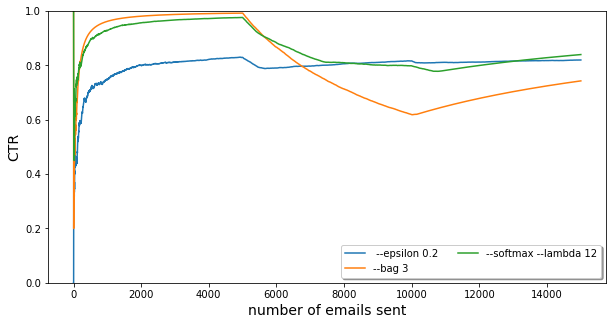

In [148]:
ctr = []
plt.figure(figsize=(10,5))
model = pyvw.vw(quiet=True)
# Instantiate learner in VW
# exploration_algo = ["--first 2", "--epsilon 0.1", "--bag 3", "--softmax --lambda 10", "--rnd 3 --epsilon 0.025" ]

# exploration_algo = ["--first 2", "--epsilon 0.1", "--bag 3", "--softmax --lambda 10", "--rnd 3 --epsilon 0.025" ]


# exploration_algo = ["--first 2", "--first 4","--first 6"]
# exploration_algo = ["--epsilon 0.05","--epsilon 0.1","--epsilon 0.15","--epsilon 0.2"]
# exploration_algo = ["--bag 1","--bag 3","--bag 5","--bag 7"]
# exploration_algo = ["--softmax --lambda 6","--softmax --lambda 8","--softmax --lambda 10","--softmax --lambda 12"]
# exploration_algo = ["--rnd 3 --epsilon 0.025","--rnd 3 --epsilon 0.025","--rnd 1 --epsilon 0.025" ]


exploration_algo = [" --epsilon 0.2" , "--bag 3","--softmax --lambda 12"]
# exploration_algo = ["--first 4"]
# exploration_algo = ["--epsilon 0.1"]
# exploration_algo = ["--bag 10"]
# exploration_algo = ["--softmax --lambda 12"]
# 
# exploration_algo = ["--epsilon 0.1" ," --epsilon 0.2" , "--softmax --lambda 10", "--bag 3"]
for algo in exploration_algo:
    
    model = pyvw.vw("--cb_explore_adf -q UA --quiet " + algo )
#     model = pyvw.vw("--cb_adf -q UA --quiet " + algo )
#     model = pyvw.vw("--cb_explore_adf --cb_type dr -q UA --quiet  " + algo )

#     for 
#     model = pyvw.vw("--explore_eval -q UA --quiet " + algo)

#     vw = pyvw.vw("--cb_explore_adf -q UA --quiet")  cubic UAK 

    num_iterations = 5000
    

    
# **********************************************************
#     USER_OPENED or USER_IGNORED
    cost_functions = [reward_func, reward_func_new1, reward_func_new2]
#     cost_functions = [reward_func]
# 
#     cost_functions = [reward_func, reward_func,reward_func]

    
# **********************************************************
# np.random.choice([0,-1],p=[0.3,0.7])

#     cost_functions = [reward_func_choice, reward_func_choice_new1 ,reward_func_choice_new2]
    
# **********************************************************
# np.random.normal(-1,0.075)   
#     cost_functions = [reward_func_normaldist, reward_func_normaldist_new1, reward_func_normaldist_new2]
#     cost_functions = [reward_func_normaldist]


    total_iterations = num_iterations * len(cost_functions)
#     print(total_iterations)
    ctr.append(run_simulation_multiple_cost_functions(model, num_iterations, users, times_of_day, actions, cost_functions))
               
    plot_ctr(total_iterations, ctr[-1],algo)
    

In [135]:
print(model.predict('1| Female afternoon'))

[1.0]


In [ ]:
ctr = []
plt.figure(figsize=(10,5))
model = pyvw.vw(quiet=True)
# Instantiate learner in VW
# exploration_algo = ["--first 2", "--epsilon 0.1", "--bag 3", "--softmax --lambda 10", "--rnd 3 --epsilon 0.025" ]

# exploration_algo = ["--first 2", "--epsilon 0.1", "--bag 3", "--softmax --lambda 10", "--rnd 3 --epsilon 0.025" ]


# exploration_algo = ["--first 2", "--first 4","--first 6"]
# exploration_algo = ["--epsilon 0.05","--epsilon 0.1","--epsilon 0.15","--epsilon 0.2"]
# exploration_algo = ["--bag 10","--bag 3","--bag 5","--bag 7"]
# exploration_algo = ["--softmax --lambda 6","--softmax --lambda 8","--softmax --lambda 10","--softmax --lambda 12"]
# exploration_algo = ["--rnd 3 --epsilon 0.025","--rnd 3 --epsilon 0.025","--rnd 1 --epsilon 0.025" ]


# exploration_algo = [" --epsilon 0.05" , "--bag 2","--softmax --lambda 18"]
# exploration_algo = ["--first 4"]
# exploration_algo = ["--epsilon 0.1"]
exploration_algo = ["--bag 1"]
# exploration_algo = ["--softmax --lambda 18"]
# 
# exploration_algo = ["--epsilon 0.1" ," --epsilon 0.2" , "--softmax --lambda 10", "--bag 3"]
for algo in exploration_algo:
    
    model = pyvw.vw("--cb_explore_adf -q UA --quiet " + algo )
#     model = pyvw.vw("--cb_adf -q UA --quiet " + algo )
#     model = pyvw.vw("--cb_explore_adf --cb_type dr -q UA --quiet  " + algo )

#     for 
#     model = pyvw.vw("--explore_eval -q UA --quiet " + algo)

#     vw = pyvw.vw("--cb_explore_adf -q UA --quiet")  cubic UAK 

    num_iterations = 1000
    

    
# **********************************************************
#     USER_OPENED or USER_IGNORED
#     cost_functions = [reward_func, reward_func_new1, reward_func_new2]
    cost_functions = [reward_func]
# 
#     cost_functions = [reward_func, reward_func,reward_func]

    
# **********************************************************
# np.random.choice([0,-1],p=[0.3,0.7])

#     cost_functions = [reward_func_choice, reward_func_choice_new1 ,reward_func_choice_new2]
    
# **********************************************************
# np.random.normal(-1,0.075)   
#     cost_functions = [reward_func_normaldist, reward_func_normaldist_new1, reward_func_normaldist_new2]
#     cost_functions = [reward_func_normaldist]


    total_iterations = num_iterations * len(cost_functions)
#     print(total_iterations)
    ctr.append(run_simulation_multiple_cost_functions(model, num_iterations, users, times_of_day, actions, cost_functions))
               
    plot_ctr(total_iterations, ctr[-1],algo)
    

In [152]:
b = {
    '1': "Male",
    '2': "Female",
    }
v= {
    '1': "morning",
    '2': "afternoon",
    }

USER_OPENED = -1
USER_IGNORED = 0
actions = ['title_1', 'title_2', 'title_3','title_4']
genders = ['Male', 'Female']
time_of_days = ['morning', 'afternoon']


# print("User:" , b , " Time of the day :" , v)

In [205]:
def guess_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    print(actions)
    print(pmf)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob


print("Please choose the user's Gender:  1 for Male  OR  2  for Female ")
usr = input()
print()
print("Please choose  Time of the day:  1 for Morning  OR  2  for Afternoon ")
tof = input()
print()
print("The user is --",b.get(usr), "-- And Time of the day is --",v.get(tof),"--")
print()

    
# context = {"user":"Fale","time_of_day":"morning","Media_type":"photo" }
context = {"user":b.get(usr),"time_of_day":v.get(tof)}
# context = {"user":"Male","time_of_day":"afternoon"}
action, prob = guess_action(model, context, actions)
print("Send: ",action)



# print("Send: ",action,prob)

Please choose the user's Gender:  1 for Male  OR  2  for Female 
1

Please choose  Time of the day:  1 for Morning  OR  2  for Afternoon 
2

The user is -- Male -- And Time of the day is -- afternoon --

['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.005814552307128906, 0.1001504436135292, 0.007252548821270466, 0.8867825269699097]
Send:  send_title_4


In [211]:
def guess_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
#     print(actions)
#     print(pmf)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob


# print("Please choose the user's Gender:  1 for Male  OR  2  for Female ")
# usr = input()
# print()
# print("Please choose  Time of the day:  1 for Morning  OR  2  for Afternoon ")
# tof = input()
# print()
# print("The user is --",b.get(usr), "-- And Time of the day is --",v.get(tof),"--")
# print()

    
# context = {"user":"Fale","time_of_day":"morning","Media_type":"photo" }
context = {"user":np.random.choice(genders),"time_of_day":np.random.choice(time_of_days)}
print(context)
# context = {"user":"Male","time_of_day":"afternoon"}
action, prob = guess_action(model, context, actions)
print("Send: ",action)


# print("Send: ",action,prob)

{'user': 'Female', 'time_of_day': 'afternoon'}
Send:  send_title_4


In [ ]:
n_rows = int(10)
dataset = []
for _ in range(n_rows):
    context = {"user":np.random.choice(genders),"time_of_day":np.random.choice(time_of_days)}
    action,prob = guess_action(model, context, actions)
        
    context['action'] = action
    context['Prob'] = prob
    dataset.append(context)
#     print (context)
df = pd.DataFrame(dataset)
df

In [40]:
ctr = []
plt.figure(figsize=(10,5))
model = pyvw.vw(quiet=True)
# Instantiate learner in VW
# exploration_algo = ["--first 2", "--epsilon 0.1", "--bag 3", "--softmax --lambda 10", "--rnd 3 --epsilon 0.025" ]

# exploration_algo = ["--first 2", "--epsilon 0.1", "--bag 3", "--softmax --lambda 10", "--rnd 3 --epsilon 0.025" ]


# exploration_algo = ["--first 2", "--first 4","--first 6"]
# exploration_algo = ["--epsilon 0.05","--epsilon 0.1","--epsilon 0.15","--epsilon 0.2"]
# exploration_algo = ["--bag 1","--bag 3","--bag 5","--bag 7"]
# exploration_algo = ["--softmax --lambda 6","--softmax --lambda 8","--softmax --lambda 10","--softmax --lambda 12"]
# exploration_algo = ["--rnd 3 --epsilon 0.025","--rnd 3 --epsilon 0.025","--rnd 1 --epsilon 0.025" ]


# exploration_algo = [" --epsilon 0.2" , "--bag 3","--softmax --lambda 15"]
# exploration_algo = ["--first 4"]
# exploration_algo = ["--epsilon 0.1"]
# exploration_algo = ["--bag 3"]
exploration_algo = ["--softmax --lambda 12"]
# 
# exploration_algo = ["--epsilon 0.1" ," --epsilon 0.2" , "--softmax --lambda 10", "--bag 3"]

for algo in exploration_algo:
    model = pyvw.vw("--cb_explore_adf -q UA --quiet " + algo)
#     vw = pyvw.vw("--cb_explore_adf -q UA --quiet") cubic UAK 

    num_iterations = 1000
    
# **********************************************************
#     USER_OPENED or USER_IGNORED
    cost_functions = [reward_func, reward_func_new1, reward_func_new2]
    
# **********************************************************


# np.random.choice([0,-1],p=[0.3,0.7])
#     cost_functions = [reward_func_choice, reward_func_choice_new1 ,reward_func_choice_new2]
    
# **********************************************************
# np.random.normal(-1,0.075)   
#     cost_functions = [reward_func_normaldist, reward_func_normaldist_new1, reward_func_normaldist_new2]

    total_iterations = num_iterations * len(cost_functions)
#     print(total_iterations)
    ctr.append(run_simulation_multiple_cost_functions(model, num_iterations, users, times_of_day, actions, cost_functions,do_learn=False))
               
    plot_ctr(total_iterations, ctr[-1],algo)

1   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  -1

2   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  -1

3   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  -1

4   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  0

5   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  0

6   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.2

[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

137   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

138   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

139   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

140   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

141   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  -1

142   {'user': 'Male', 'time_of_day': 'afternoon'


285   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

286   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

287   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  -1

288   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  -1

289   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  0

290   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4'

401   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

402   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

403   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  0

404   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  0

405   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

406   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title

[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

526   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  0

527   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

528   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

529   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

530   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

531   {'user': 'Female', 'time_of_day': 'afterno

Action: send_title_4 reward is:  0

660   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

661   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

662   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

663   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

664   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  -1

665   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2'

Action: send_title_1 reward is:  0

769   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  0

770   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  0

771   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  0

772   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  0

773   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  -1

774   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2'

897   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

898   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

899   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  -1

900   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  0

901   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

902   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_

['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1053   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  -1

1054   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1055   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1056   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

1057   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 rewa

Action: send_title_3 reward is:  0

1145   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1146   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  -1

1147   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  -1

1148   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  -1

1149   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  -1

1150   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'se

Action: send_title_4 reward is:  0

1285   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1286   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1287   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

1288   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  0

1289   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  0

1290   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send

Action: send_title_1 reward is:  0

1390   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  0

1391   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  -1

1392   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1393   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  -1

1394   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1395   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1

['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  -1

1534   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  0

1535   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

1536   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  -1

1537   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  0

1538   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_tit

Action: send_title_3 reward is:  0

1653   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  0

1654   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  0

1655   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1656   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  -1

1657   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1658   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'sen

Action: send_title_2 reward is:  -1

1770   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1771   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  0

1772   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  0

1773   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  -1

1774   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

1775   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1',

1924   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1925   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  0

1926   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_3 reward is:  0

1927   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

1928   {'user': 'Male', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  0

1929   {'user': 'Female', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_tit

['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  0

2043   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

2044   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_4 reward is:  -1

2045   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_1 reward is:  0

2046   {'user': 'Male', 'time_of_day': 'afternoon'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_2 reward is:  0

2047   {'user': 'Female', 'time_of_day': 'morning'}
['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4']
[0.25, 0.25, 0.25, 0.25]
Action: send_title_

KeyboardInterrupt: 

<Figure size 720x360 with 0 Axes>

In [41]:
def guess_action(vw, context, actions):
    
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    print(actions,pmf)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

context = {"user":"Female","time_of_day":"morning" }

action, prob = guess_action(model, context, actions)
print("Send: ",action)
# print(action,prob)

['send_title_1', 'send_title_2', 'send_title_3', 'send_title_4'] [0.25, 0.25, 0.25, 0.25]
Send:  send_title_2


# <span style="color:red"> **Distributions** </span>

### 1st One
np.random.choice([0,-1],p=[0.3,0.7])

In [22]:
def reward_func_choice(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'send_title_1':
            return np.random.choice([0,-1],p=[0.3,0.7])
        elif context['time_of_day'] == "afternoon" and action == 'send_title_3':
            return np.random.choice([0,-1],p=[0.4,0.6])
        else:
            return USER_IGNORED
        
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'send_title_2':
            return np.random.choice([0,-1],p=[0.3,0.7])  
        elif context['time_of_day'] == "afternoon" and action == 'send_title_1':
            return np.random.choice([0,-1],p=[0.4,0.6])
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_choice)

actions              send_title_1  send_title_2  send_title_3  send_title_4
users  times_of_day                                                        
Female afternoon                0             0             0             0
       morning                  0            -1             0             0
Male   afternoon                0             0            -1             0
       morning                 -1             0             0             0

In [23]:

def reward_func_choice_new1(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'send_title_1':
            return np.random.choice([0,-1],p=[0.3,0.7])
        elif context['time_of_day'] == "afternoon" and action == 'send_title_2':
            return np.random.choice([0,-1],p=[0.3,0.7])
        else:
            return USER_IGNORED
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'send_title_3':
            return np.random.choice([0,-1],p=[0.4,0.6])
        elif context['time_of_day'] == "afternoon" and action == 'send_title_2':
            return np.random.choice([0,-1],p=[0.4,0.6])
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_choice_new1)

actions              send_title_1  send_title_2  send_title_3  send_title_4
users  times_of_day                                                        
Female afternoon                0             0             0             0
       morning                  0             0            -1             0
Male   afternoon                0            -1             0             0
       morning                 -1             0             0             0

In [24]:
def reward_func_choice_new2(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'send_title_1':
            return np.random.choice([0,-1],p=[0.3,0.7])
        elif context['time_of_day'] == "afternoon" and action == 'title_4':
            return np.random.choice([0,-1],p=[0.1,0.9])
        else:
            return USER_IGNORED
    elif context['user'] == "Female": 
        if context['time_of_day'] == "morning" and action == 'send_title_2':
            return np.random.choice([0,-1],p=[0.1,0.9])
        elif context['time_of_day'] == "afternoon" and action == 'title_4':
            return np.random.choice([0,-1],p=[0.1,0.9])
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_choice_new2)

actions              send_title_1  send_title_2  send_title_3  send_title_4
users  times_of_day                                                        
Female afternoon                0             0             0             0
       morning                  0            -1             0             0
Male   afternoon                0             0             0             0
       morning                  0             0             0             0

## 2nd One

USER_OPENED or USER_IGNORED

In [25]:
def reward_func(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'send_title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'send_title_3':
            return USER_OPENED
        else:
            return USER_IGNORED
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'send_title_2':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'send_title_1':
            return USER_OPENED
        else:
            return USER_IGNORED
get_preference_matrix(reward_func)

actions              send_title_1  send_title_2  send_title_3  send_title_4
users  times_of_day                                                        
Female afternoon               -1             0             0             0
       morning                  0            -1             0             0
Male   afternoon                0             0            -1             0
       morning                 -1             0             0             0

In [26]:
def reward_func_new1(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'send_title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'send_title_2':
            return USER_OPENED
        else:
            return USER_IGNORED
        
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'send_title_3':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'send_title_2':
            return USER_OPENED
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_new1)

actions              send_title_1  send_title_2  send_title_3  send_title_4
users  times_of_day                                                        
Female afternoon                0            -1             0             0
       morning                  0             0            -1             0
Male   afternoon                0            -1             0             0
       morning                 -1             0             0             0

In [27]:
def reward_func_new2(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'send_title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'send_title_4':
            return USER_OPENED
        else:
            return USER_IGNORED
        
    elif context['user'] == "Female": 
        if context['time_of_day'] == "morning" and action == 'send_title_2':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'send_title_4':
            return USER_OPENED
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_new2)

actions              send_title_1  send_title_2  send_title_3  send_title_4
users  times_of_day                                                        
Female afternoon                0             0             0            -1
       morning                  0            -1             0             0
Male   afternoon                0             0             0            -1
       morning                 -1             0             0             0

## 3rd One

np.random.normal(-1,0.075) 

In [28]:
def reward_func_normaldist(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'send_title_1':
            return np.random.normal(-1,0.4) 
        elif context['time_of_day'] == "afternoon" and action == 'send_title_3':
            return np.random.normal(-1,0.4) 
        else:
            return USER_IGNORED
        
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'send_title_2':
            return np.random.normal(-1,0.4) 
        elif context['time_of_day'] == "afternoon" and action == 'send_title_1':
            return np.random.normal(-1,0.4) 
        else:
            return USER_IGNORED
get_preference_matrix(reward_func_normaldist)

actions              send_title_1  send_title_2  send_title_3  send_title_4
users  times_of_day                                                        
Female afternoon        -0.433205      0.000000      0.000000           0.0
       morning           0.000000     -1.138076      0.000000           0.0
Male   afternoon         0.000000      0.000000     -0.918565           0.0
       morning          -1.211660      0.000000      0.000000           0.0

In [29]:
def reward_func_normaldist_new1(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'send_title_1':
            return np.random.normal(-1,0.1) 
        elif context['time_of_day'] == "afternoon" and action == 'send_title_2':
            return np.random.normal(-1,0.1) 
        else:
            return USER_IGNORED
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'send_title_3':
            return np.random.normal(-1,0.1) 
        elif context['time_of_day'] == "afternoon" and action == 'send_title_2':
            return np.random.normal(-1,0.1) 
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_normaldist_new1)

actions              send_title_1  send_title_2  send_title_3  send_title_4
users  times_of_day                                                        
Female afternoon         0.000000     -1.096167       0.00000           0.0
       morning           0.000000      0.000000      -0.93236           0.0
Male   afternoon         0.000000     -1.024211       0.00000           0.0
       morning          -0.842438      0.000000       0.00000           0.0

In [30]:
def reward_func_normaldist_new2(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'send_title_1':
            return np.random.normal(-1,0.1)
        elif context['time_of_day'] == "afternoon" and action == 'send_title_4':
            return np.random.normal(-1,0.1)
        else:
            return USER_IGNORED
    elif context['user'] == "Female": 
        if context['time_of_day'] == "morning" and action == 'send_title_2':
            return np.random.normal(-1,0.1)
        elif context['time_of_day'] == "afternoon" and action == 'send_title_4':
            return np.random.normal(-1,0.1)
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_normaldist_new2)

actions              send_title_1  send_title_2  send_title_3  send_title_4
users  times_of_day                                                        
Female afternoon         0.000000      0.000000           0.0     -0.996040
       morning           0.000000     -1.084442           0.0      0.000000
Male   afternoon         0.000000      0.000000           0.0     -1.028637
       morning          -0.992478      0.000000           0.0      0.000000